# Embedding 

The aim of this notebook is to test the embedding model and see if the results look logical for the naked eye. 
What is more, Bokeh and pyvis will be tested for generating the network graphs.

## Imports

In [1]:
# add root path to system path
import sys
sys.path.append('../')

In [2]:
import itertools

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sentence_transformers import SentenceTransformer
from bokeh.plotting import figure, from_networkx
from bokeh.transform import linear_cmap
from bokeh.models import Circle, MultiLine
from bokeh.io import output_notebook, show
from bokeh.palettes import Blues8
from scripts.helpers import get_embedding
from pyvis.network import Network

## Data

Note that data preprocessing has been done in [preprocess.ipynb](preprocess.ipynb). The notebook will clean, merge and save the data to `data/processed`.

In [3]:
df = pd.read_csv('../data/processed/preprocessed.csv', index_col=0)
print(df.shape)
df.head(5)

(22394, 10)


,name,release_year,rating,num_votes,wikipedia_id,plot,freebase_id,languages,countries,genres
0,Miss Jerry,1894.0,5.3,207,10109752,After finding out that her father is suffering...,/m/02q23xk,['Silent film'],['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-..."
1,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,28703057,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],['Sports']
2,The Story of the Kelly Gang,1906.0,6.0,855,142995,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,['English Language'],['Australia'],"['Crime Fiction', 'Silent film', 'Biography', ..."
3,Robbery Under Arms,1907.0,4.3,25,32986669,Key scenes of the film included the branding o...,/m/04p7yxx,['Silent film'],['Australia'],"['Silent film', 'Drama']"
4,"Captain Midnight, the Bush King",1911.0,5.4,18,32987200,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,['Silent film'],[],['Silent film']


In [4]:
# let's take the subsample of the data for testing
sample_df = df.sample(100)

## Embedding

We're using the model described in this [paper](https://arxiv.org/pdf/2212.03533.pdf), which can be downloaded [here](https://huggingface.co/intfloat/e5-large-v2). To download the model, run in the `models` directory:

```
git lfs install
git clone https://huggingface.co/intfloat/e5-large-v2
```

### Modelling

In [5]:
model = SentenceTransformer('../models/e5-large-v2')

In [6]:
# create dictionary with embeddings for all the movies
input_template = 'query: {}'
embeddings = {}

for index, row in sample_df.iterrows():
    plot = input_template.format(row['plot'])
    movie = row['name']
    embeddings[movie] = get_embedding(plot, model)

### Similarity Matrix

Once we have vectorized the plots, we can calculate the similarities between the plots with dot product.

In [7]:
# generate all possible combinations for dot product 
movie_sample = list(embeddings.keys())
combinations = list(itertools.combinations(movie_sample, 2))

In [8]:
# generate the similarity matrix
similarity_matrix = pd.DataFrame(index=movie_sample, columns=movie_sample, dtype=float)

for (movie_1, movie_2) in combinations:
    similarity = embeddings[movie_1] @ embeddings[movie_2]
    similarity_matrix.at[movie_1, movie_2] = similarity
    similarity_matrix.at[movie_2, movie_1] = similarity

similarity_matrix.head(5)

,One Spy Too Many,The Cry of the Owl,Kizhakku Mugam,Rocktober Blood,Chandralekha,The Death Kiss,Peopletoys,Lulu on the Bridge,Killer Elite,The Hasty Heart,...,Sufi Paranja Katha,Coach Carter,Turn Back the Clock,American Pie 2,Flicka,Nancy Drew and the Hidden Staircase,WarGames,Plug & Pray,Saaya,Rogue Cop
One Spy Too Many,NaN,0.725874,0.728507,0.728543,0.733642,0.722383,0.723016,0.724074,0.733493,0.731336,...,0.710230,0.724061,0.734351,0.719561,0.717690,0.721015,0.737729,0.728506,0.727340,0.732694
The Cry of the Owl,0.725874,NaN,0.739080,0.740032,0.743837,0.736901,0.736013,0.737576,0.743395,0.730509,...,0.708596,0.725953,0.728675,0.739502,0.748072,0.739814,0.728402,0.704600,0.741818,0.748463
Kizhakku Mugam,0.728507,0.739080,NaN,0.731908,0.766938,0.716095,0.730541,0.726478,0.733336,0.729628,...,0.744353,0.722860,0.721656,0.729433,0.733760,0.729900,0.726028,0.713357,0.750194,0.740840
Rocktober Blood,0.728543,0.740032,0.731908,NaN,0.730105,0.728989,0.735598,0.737084,0.733078,0.734812,...,0.701595,0.723765,0.730989,0.737015,0.734445,0.731758,0.728274,0.708320,0.734638,0.736966
Chandralekha,0.733642,0.743837,0.766938,0.730105,NaN,0.723613,0.730453,0.735144,0.741140,0.729147,...,0.742228,0.726935,0.729542,0.732884,0.735852,0.736806,0.732349,0.714688,0.753341,0.743637


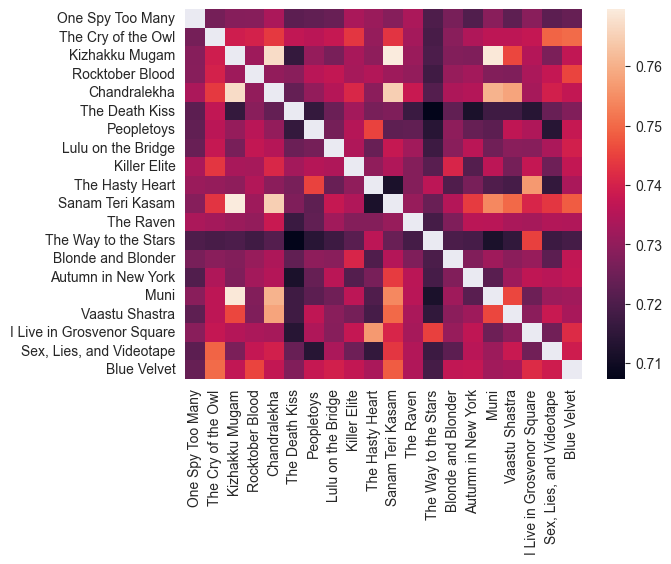

In [9]:
# let's plot the first 20 movies and their similarity matrix
first_20 = similarity_matrix.columns[:20].tolist()
sample_similarity_matrix = similarity_matrix.loc[first_20, first_20]

sns.heatmap(sample_similarity_matrix)
plt.show();

<AxesSubplot:title={'center':'Distribution of similarity values'}, ylabel='Frequency'>

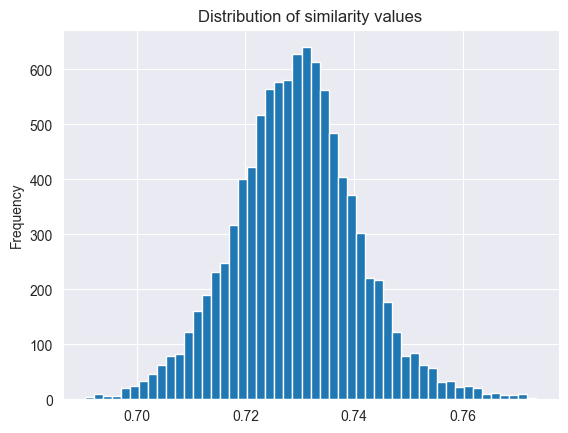

In [10]:
# let's check the distribution of similarity values
similarity_values_array = similarity_matrix.values
similarity_values = similarity_values_array[~np.isnan(similarity_values_array)]
pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [11]:
# let's show descriptive statistics
pd.Series(similarity_values).describe()

count    9900.000000
mean        0.729269
std         0.011479
min         0.690510
25%         0.722067
50%         0.729343
75%         0.736287
max         0.773448
dtype: float64

## Graph Generation

Now that we have the similarities between the movies, we can set the threshold and generate a network of nodes.

### NetworkX

In [21]:
similarity_threshold = 0.736287  # let's take 75th percentile

nodes_df = pd.DataFrame(columns=['Source', 'Target', 'Weight'])

G = nx.Graph()
G.add_nodes_from(sample_df.name.tolist())
for (movie_1, movie_2) in combinations:
    similarity = similarity_matrix.at[movie_1, movie_2]
    if similarity > similarity_threshold:
        nodes_df.loc[len(nodes_df)] = [movie_1, movie_2, similarity]
        
G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [22]:
# add name as an attribute
names = dict((name, name) for name in G.nodes)
nx.set_node_attributes(G, name='name', values=names)

In [23]:
# calculate the betweenness centrality
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, name='betweenness', values=betweenness)

In [24]:
# calculate degree for each node
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

In [25]:
# add movie rating
ratings = sample_df.set_index('name').rating

ratings_dict = dict((name, ratings.loc[name]) for name in G.nodes)
nx.set_node_attributes(G, name='rating', values=ratings_dict)

### Bokeh

In [26]:
# adjust the size of the nodes by normalizing the revenue
ratings_normalized = (ratings - ratings.min()) / (ratings.max() - ratings.min())

adjusted_node_size = dict((name, ratings_normalized.loc[name] * 20 + 10) for name in G.nodes)
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [27]:
# hacky way to rename the nodes since bokeh couldn't otherwise handle that
mapping = dict((n, i) for i, n in enumerate(G.nodes))
H = nx.relabel_nodes(G, mapping)

In [28]:
output_notebook()

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'betweenness'

color_palette = Blues8

# establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Name", "@name"), ("Rating", "@rating"), ("'Being at the intersection'", "@betweenness")]

# create a plot — set dimensions, toolbar, and title
plot = figure(
    width=1000, 
    height=600,
    tooltips = HOVER_TOOLTIPS,
    tools="pan,wheel_zoom,save,reset", 
    active_scroll='wheel_zoom'
)

plot.axis.visible = False
plot.grid.visible = False

# create a network graph object with spring layout
network_graph = from_networkx(H, nx.spring_layout, scale=10, center=(0, 0))

# set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

# set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

# set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

# add network graph to the plot
plot.renderers.append(network_graph)

show(plot)

Loading BokehJS ...

Since html graphs are not visible in Jupyter Notebooks, I'll add a png here for the reference.
<br>
<img src="img/bokeh_example.png">
<br>
The size of the node represents the rating, whereas the color "being at the intersection" (light color -> more at the intersections).

Bokeh seems a good approach with many good features, but few limitations:
- not an easy way for saving a chart that's edited manually (e.g. zoomed in)
- documentation is quite bad
- requires many extra features and hacking even the PATH for making it work

The html versions could be good to embed to the final website.

### Pyvis

In [29]:
nt = Network('600px', '900px', cdn_resources='in_line')
nt.from_nx(G)
nt.show('pyvis_example.html')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Pyvis tends to be quite heavy and could only be an option with smaller subsets and simpler examples.
As Plotly and Matplotlib turned out to be really unsuitable for plotting networks, it seems that 

As html is still not accessible in Jupyter Notebooks, I'll plot the img version of it.
<br>
<img src="img/pyvis_example.png">
<br>
It seems that pyvis needs much more tweaking to get to the point where it would be convenient to analyse.

## Summary

Based on the first network graph, it seems that the approach where we simply embed the plots doesn't generate clusters, 
but a one big hive. This will not be a problem since we can still test our hypothesis. Alternatively, we could use another graph generation logic described in readme.

Another challenge lies in plotting the networks in Jupyter notebooks. As the graphs are quite complex and most packages use html as the output, 
they are not visible in e.g. GitHub. Luckily Github pages with Jekyll support embedded html, so it should be fine.